### connect to Fit-Gauß
erste Probeanalyse

In [1]:
#Imports
from matplotlib import pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import label, find_objects, median_filter
import scipy.stats

<class 'numpy.ndarray'>
(1456, 1936, 3)
uint8


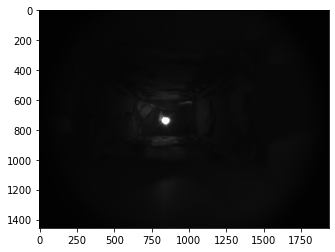

In [2]:
####erstes Probebild von Versuch 2 mit vimba software erzeugt
####Bild mit opencv laden

im = cv2.imread('D:\\HZB\\BA_epics_camera\\Testaufbau\\Versuch2\\Stoff_im_Gang_Tuch_vor_Handy.bmp')

print(type(im))
print(im.shape)
print(im.dtype)

plt.imshow(im, cmap='gray')
plt.show()

(1456, 1936)
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 3 2 2]
 [2 2 3 ... 2 2 2]
 [2 2 2 ... 2 3 2]]


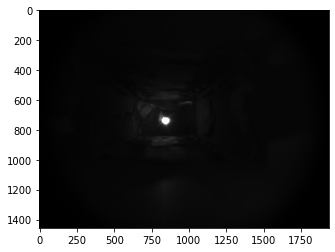

In [3]:
# reshape image, nachdem es nach dem Laden ausversehen in allen rgb Farben das gleiche stehen hat

def rgb2gray(Img):
    row,col,ch = Img.shape
    g = [ ]  
    for i in range(row) :
        a = []
        for j in range(col):
            a.append(Img[i,j,0])
        g.append(a)
    gr = np.array(g)
    return gr

grIm = rgb2gray(im)
print(grIm.shape)
print(grIm)
plt.imshow(grIm, cmap='gray')
plt.show()

Schwellwert: 2


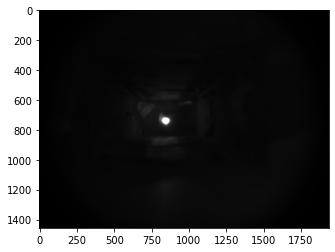

In [4]:
####label areas

#schwellwert finden 
print("Schwellwert:", scipy.stats.mode(grIm)[0][0][0])

#weitere Überlegung: outliers durch median filter ausbügeln -> Bild zwar verschwommen, aber dafür weniger falsche areas
#median_filter braucht länger Zeit
#wird im Folgenden nicht benutzt, beim testlauf damit wurde eindeutiges Ergebnis mit gleichem Schwellwert erzeugt
filt_im = median_filter(grIm, size=(20,20))
#vlt kleinerer Bereich? vlt auch schon scneller
plt.imshow(filt_im,cmap='gray')
plt.show()

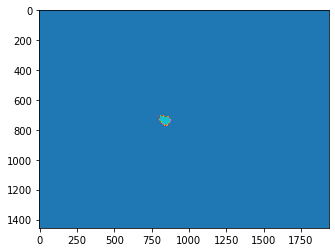

In [5]:
####bestimme entscheidende area und benutze nur noch die area of interest
####hier area of interest manuell, später mit algorithmus finden

filtered_im = (grIm > 70) # Schwellwert "> 2" hat zu viele label erzeugt, 
# weitere Idee "Segmentation with Gaussian mixture models"
# https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_GMM.html#sphx-glr-advanced-image-processing-auto-examples-plot-gmm-py

plt.imshow(filtered_im,cmap='tab10')
plt.show()

4


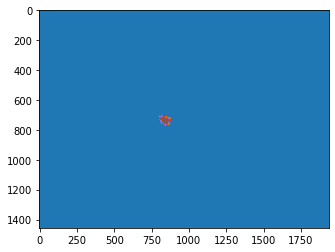

In [6]:
labeled_im, num_label_im= label (filtered_im)
print(num_label_im)
#print(labeled_im)
plt.imshow(labeled_im,cmap='tab10')
plt.show()

4
Index: 0


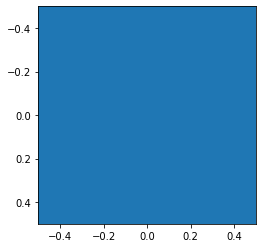

Index: 1


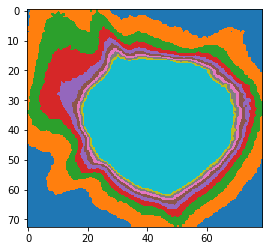

Index: 2


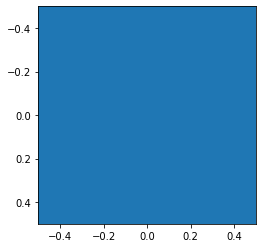

Index: 3


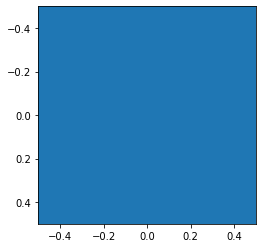

In [7]:
im_parts = find_objects(labeled_im)
# good_parts = []
# for parts in im_parts:
#     if labeled_im[parts].shape[0] > 100:
#         good_parts.append(parts)
len_parts = len(im_parts)
print(len_parts)

for i in range(0,len_parts):
    print("Index:", i)
    plt.imshow(grIm[im_parts[i]],cmap='tab10')
    plt.show()


  

--> Parameter die Einfluss auf das finden der besten Area haben beim labeln:
- median filter oder nicht (filter braucht zeit, aber eleminiert Outliers und liefert nur alle wichtigen Areas)
- Schwellwert (was gehört zu Lichtfleck, was nicht?) nur den häufigsten Wert des Bildes nehmen, liefert zu viele Areas, vlt "Segmentation with Gaussian mixture models" bei https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_GMM.html#sphx-glr-advanced-image-processing-auto-examples-plot-gmm-py testen

--> weitere Gedanken:
- vlt Funktion finden, die schnell alle nicht wichtigen areas eleminiert Bsp "Clean up small connect components:" bei https://scipy-lectures.org/advanced/image_processing/#segmentation
- find_object schneidet area sehr eng ab, vlt immer noch die slices bis zum Rand vergrößern, wäre nochma eigene funktion, oder vlt durch recherche etwas finden 
- labeln allg. schneller als clustering, außer median filter, aber selbst der keine Wartezeiten wie clustering, kein reshapen 
- Idee wenn noch Zeit: mit timeit genau Berechnungszeiten überprüfen und in Tabelle darstellen 

(slice(701, 774, None), slice(801, 880, None))
(slice(651, 824, None), slice(751, 930, None))


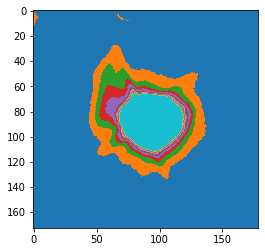

In [8]:
####Fit-Gauß Analyse für diesen Bereich 

#slice grIm nicely so wie durch labeln berechnet 
our_part = im_parts[1]
print(our_part)
new_slice = (slice(our_part[0].start - 50, our_part[0].stop + 50, None), 
             slice(our_part[1].start - 50, our_part[1].stop + 50, None))
print(new_slice)

roi = grIm[new_slice] #region of interest
plt.imshow(roi,cmap='tab10')
plt.show()

#später noch überlegen was mit parts am Rand ist! dann geht +- 50 nicht

In [31]:
# save so it can be reloaded somewhere else
with open('roi.npy', 'wb') as f:
    np.save(f, roi)

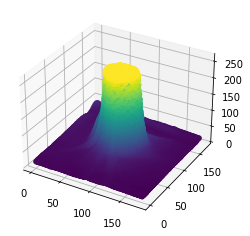

In [9]:
#### visualize in 3D
#print("roi", roi.shape, roi)
z_werte = roi
roi_x = roi.shape[1]
roi_y = roi.shape[0]
x_werte = np.repeat(np.array([range(0,roi_x)]), roi_y, axis=0) 
#print("x", x_werte.shape, x_werte)
y_werte = np.repeat(np.array([range(roi_y-1, -1, -1)]).reshape(roi_y,1), roi_x, axis=1)
#print("y", y_werte.shape, y_werte)

ax = plt.axes(projection='3d')
ax.scatter(x_werte, y_werte, z_werte, c=z_werte, cmap='viridis', linewidth=0.5)


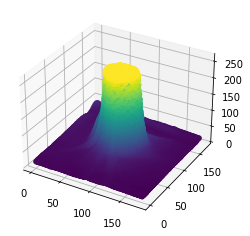

In [10]:
#### fit gauß

#Vorbereitung Fit: alles flatten 
x_werte = x_werte.flatten()
y_werte = y_werte.flatten()
z_werte = z_werte.flatten()

ax = plt.axes(projection='3d')
ax.scatter(x_werte, y_werte, z_werte, c=z_werte, cmap='viridis', linewidth=0.5)


In [11]:
#damit curve_fit nur ein independent variable object hat müssen x_werte und y_werte zu einem
#2D array zusammen geführt werden 

#zusammen führen von np.arrays
x_werte_y_werte = np.column_stack((x_werte,y_werte))
print(x_werte_y_werte.shape, "\n", x_werte_y_werte)


(30967, 2) 
 [[  0 172]
 [  1 172]
 [  2 172]
 ...
 [176   0]
 [177   0]
 [178   0]]


In [12]:
#entspricht mathematischer gauss funktion
def gauss_func (x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2.)

#"rechne mir für x,y den z-wert mit gauß aus"
#präziserer Gauß???? nicht nur eine Achsen ( kippen möglich)
def gauss_func_3D (x, y,  mu_x, sig_x, mu_y, sig_y):
    return np.multiply(gauss_func(x, mu_x, sig_x),gauss_func(y, mu_y, sig_y))

# function die beim Fit aufgerufen wird 
def func(x_y,  mu_x, sig_x, mu_y, sig_y):
    x, y = np.hsplit(x_y, 2)
    return gauss_func_3D(x.flatten(),y.flatten(),mu_x,sig_x,mu_y,sig_y)

In [13]:
from scipy.optimize import curve_fit

In [14]:
#Fit aufrufen
popt_bound, pcov = curve_fit(func, x_werte_y_werte, z_werte)
#new parameters:
popt_bound

array([93.08684727, -4.52992276, 86.23392181, -2.65004099])

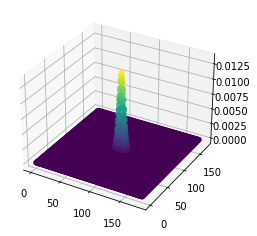

In [15]:
#um zu gucken wie gut Fit war z_werte mit den neuen parametern berechnen und gucken, ob es noch gauß mäßiger aussieht 

z_werte_fitted = gauss_func_3D(x_werte, y_werte, popt_bound[0], popt_bound[1], popt_bound[2], popt_bound[3])
ax = plt.axes(projection='3d')
ax.scatter(x_werte, y_werte, z_werte_fitted, c=z_werte_fitted, cmap='viridis', linewidth=0.5)

In [16]:
#mhhh die neue Kurve ist ja nich so der renner ....
#vlt curve fit tatsächlich nich so gut für 3d Fit vlt bessere Bibliothek?

weitere Gedanken: 
- curve_fit scheint erstmal nicht unmengen Zeit zu verbrauchen
- Gründe warum vlt Parameter verfälscht sind: Kurve in roh Daten oben abgeschnitten (könnte an Testaufbau liegen, vlt andere lampen besseres Licht), oder der curve_fit kann nicht so gut mehr-dimensional fitten
- Idee: an den curve_fit Voreinsetllungen spielen --> besser wenn von 1D Fit (hier f(x)) vorbereitet (f(x) UND f(y))
- weiterhin ungeklärt ist Entscheidung welcher der gelabelten Bereiche genommen werden soll, außerdem bisher nicht geregelt wasa mit Bereichen am Rand passiert 
- Idee: region of interest manuell einmal festlegen und dann mitwandern lassen (größe und Zentrum anpassen, qualität des Fit ergbnisses testen))



In [28]:
#Idee: gauss-Stumpf Funktion
#####abgelehnt 
#entspricht mathematischer gauss funktion
def gauss_func (x, mu, sig):
    y = 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2.)
    y[y > 255] = 255
    return y

#"rechne mir für x,y den z-wert mit gauß aus"
def gauss_func_3D (x, y,  mu_x, sig_x, mu_y, sig_y):
    return np.multiply(gauss_func(x, mu_x, sig_x),gauss_func(y, mu_y, sig_y))

# function die beim Fit aufgerufen wird 
def func(x_y,  mu_x, sig_x, mu_y, sig_y):
    x, y = np.hsplit(x_y, 2)
    return gauss_func_3D(x.flatten(),y.flatten(),mu_x,sig_x,mu_y,sig_y)

In [29]:
popt_bound, pcov = curve_fit(func, x_werte_y_werte, z_werte)
#new parameters:
popt_bound

array([93.08684727, -4.52992276, 86.23392181, -2.65004099])

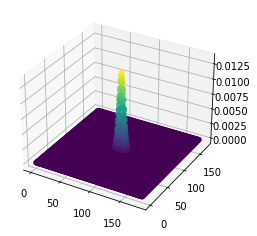

In [27]:
z_werte_fitted = gauss_func_3D(x_werte, y_werte, popt_bound[0], popt_bound[1], popt_bound[2], popt_bound[3])
ax = plt.axes(projection='3d')
ax.scatter(x_werte, y_werte, z_werte_fitted, c=z_werte_fitted, cmap='viridis', linewidth=0.5)

In [ ]:
#Die Werte haben sich trotz max überarbeitung nicht geändert

# Optimierungsideen 
- 2d fit mit 1D füttern, notwendigkeit
- Zahl der Punkte im 2D fit verkleinern, dabei Idee: heller Punkte sind interessanter, also vlt in Stufen auswählen --> Auswahl Zeitlich überprüfen/verbessern
- 2D Fit andere Algorithmen finden und testen 

# Ideen zum besseren Bilder aufnehmen
- Belichtungszeit reduzieren 
- Linse unschärfer
